# Latent Dirichlet Allocation for Project Gutenberg Data

This notebooks presents analysis of the project Gutenberg library using Latent Dirichlet Allocation dimensionality reduction and K-Means clustering. 
Two datasets will be analyzed, one which was presorted according to "bookshelves" on the Gutenberg respository, to compare clusterings achieved with LDA and K-Means with those done by humans.

This notebook will present the functions and the methods used, and some example analysis. The full analysis with conclusions is presented in the report.

In [1]:
import pandas as pd
import glob
import random
import nltk
import string
import os
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from gensim import corpora
from gensim import models
from gensim import matutils
from matplotlib import pyplot as plt
from nltk.stem import PorterStemmer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.metrics import mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
from math import pi
import pickle
import sys

C:\Users\david.murer\AppData\Local\conda\conda\envs\text_processing_2\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
sys.path.append('./ProjectLibrary/')

Import parsing and preprocessing as well as plot functions.
Details of the parsing and preprocessing as discussed in the report are handled inside these functions.

In [3]:
import FileParsing
reload(FileParsing)
import PlotFunctions
reload(PlotFunctions)
from FileParsing import TextProcessor
from FileParsing import Corpus
from PlotFunctions import plotModel

download two packages required for nltk

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david.murer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david.murer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

adapt figure size, notebook size

In [3]:
from IPython.core.display import display, HTML
from matplotlib import pyplot as plt
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams['figure.figsize']=(15,10)
plt.rcParams['font.size']=20

In [6]:
import sys  
stdout=sys.stdout 
#sys.setdefaultencoding('utf8')
#need this line, otherwise print output not printed in notebook
sys.stdout = stdout

Enable logging. Needed to check vor convergence. File will be created in the folder the notebook is

In [7]:
import logging
logging.basicConfig(filename='gensim.log',format="%(asctime)s:%(levelname)s:%(message)s",level=logging.DEBUG)

Configuration, configure number of topics and number of clusters.
if useRandomSet is True, a random selection books from the full Gutenberg repository will be selected.
Let us explore a random set of 500 books from the gutenberg project using 10 clusters and 15 topics.

Adapt basepath to the gutenberg data folder.

In [7]:
nTopics=10
nClusters=10
useRandomSet=True
nRandomTitles=500
basePath= "C:/Users/david.murer/gutenberg_capstone_project/data/"

Create a TextProcessor object. This is code to open and parse the books, extract relevant information (title, author, fulltext), deal with the encoding of the books, convert it to BOW representation, conduct preprocessing (i.e. remove stopwords, remove garbage such as formatting code and perform stemming).

In [10]:
parsing=TextProcessor(basePath,useRandomSet,nRandomTitles)

Lets have a brief look at the main function of the TextProcessor object.
The functions are documented, documentation can be accessed with a question mark after the function name

In [22]:
parsing.preProcessText?

Initialize the random choice of documents from the Gutenberg repository. Doesn't do anything for the HSD datasets. This will select 500 books which can be opened and parsed. Some of the books have not enough text or formatting which cannot be processed. Such books are ignored

In [ ]:
parsing.initializeRandomSet()

Define a function to classify documents using the given clusterers, dictionary, LDA model and return a dataframe containing for each document the book title, author, the human selected category (if applicable), the cluster id for the LDA reduced datasets, the cluster id of the PCA reduced datasets, an id for the random cluster id as well as the document representation in topics

In [8]:
def classifyDocuments(text_processor,clusterer_lda, clusterer_pca,dictionary,model,pca_reduced_corpus):
    clms=['fname','author','title','random_cluster_id','lda_cluster_id','pca_cluster_id','category']
    topics_name=['topic_'+str(t) for t in range(0,nTopics)]
    clms=clms+topics_name
    df=pd.DataFrame(columns=clms)
    paths=text_processor.returnAllPaths()
    nWordsInDictionary=len(dictionary.items())

    for idx,p in enumerate(paths):
        fname=p.split("\\")[-1]
        author,title,full_text,endFound =text_processor.openFileWithIds(p)
        data_dict={'fname':fname,'author':author,'title':title,'random_cluster_id':0,'lda_cluster_id':0,'pca_cluster_id':0}
        doc_bow=dictionary.doc2bow(text_processor.preProcessText(full_text,title))
        transformed=matutils.sparse2full(model[doc_bow],nTopics)
        full_doc=matutils.sparse2full(doc_bow,nWordsInDictionary).reshape(nWordsInDictionary,1)
        data_dict['lda_cluster_id']=clusterer_lda.predict(transformed.reshape(1,-1))[0]
        data_dict['random_cluster_id']=np.random.choice(range(0,nClusters))
        data_dict['pca_cluster_id']=clusterer_pca.predict(pca_reduced_corpus[idx,:].reshape(1,-1))[0]
        
        
        if not useRandomSet:
            data_dict['category']=text_processor.extractCategory(p)
        for key,val in data_dict.items():
            df.loc[idx,key] = val
        df.loc[idx,topics_name]=transformed
    return df

Create dictionary for the books and save it to disk

In [12]:
%%time
dictionary= corpora.Dictionary()
paths=parsing.returnAllPaths()
for path in paths:
    author,title,full_text,endFound=parsing.openFileWithIds(path)
    document=parsing.preProcessText(full_text,title)
    dictionary.add_documents([document])
    
dictionary.save('./dictionary_with_stemming_random_selection.dict')  # store the dictionary, for future reference

end not found for filepathC:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\anthropology\haeckel_evoluation_man.txt
C:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\anthropology\haeckel_evoluation_man.txt
end not found for filepathC:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\christianity\pg1653.txt
C:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\christianity\pg1653.txt
Wall time: 5min 25s


Lets inspect the dictionary.

In [158]:
dictionary.num_docs

500

How many words are in the dictionary?

In [159]:
len(dictionary.items())

422456

load the dictionary to avoid building it twice

In [29]:
dictionary = corpora.Dictionary.load('./dictionary_with_stemming_random_selection.dict')

Lets learn a LDA model on the chosen data set. As is discussed in the report, more pronounced clusters can be achieved by filtering out words which occur not too frequently.
This is makes intuitive sense, as highly common words do not carry any information about where they are coming from. Thus, only use words which occur at most in 40% of the documents.
At the same time, words which are too rare are not very useful as well, as they might be things as names and just too specific as to carry any meaning.
Thus, require that each word must at least occur in at least 10 documents. Justification for these parameter is given in the report, however it is also the results of some trial and error, inspecting the sensibility of the word distribution in the topics. Are there many names? Many very common words? The report discusses the impact of these parameters on the Silhouette score of the resulting clusters

In [162]:
dictionary.filter_extremes(no_below=10,no_above=0.4)

How many words are left?

In [163]:
len(dictionary.items())

23814

Learn a dictionary, using the Corpus class defined in the FileParsing.py file.
This Corpus class defines an iterator over the books, which loads the books from the harddrive. Check the log file to see if the model converged, with the selected parameters its usually ok

In [164]:
%%time
nWordsInDictionary=len(dictionary.items())
corpus=Corpus(dictionary,parsing)
model = models.LdaModel(corpus, id2word=dictionary, num_topics=nTopics,passes=4,iterations=50000)

Wall time: 3min 31s


Lets print the most common words of all the topics.

Lets print the most common words of all topics. A few interesting observations:
- there seem to be topics associated with religion (e.g. topic 4, "christ", "jesu", "sinner", "gospel") 
- there seem to be German books in the repository (topic 8 consist solely of German words)
- not all topics have a ready interpretation, e.g. its hard to make much sense of topic 0

In [166]:
model.print_topics()

[(0,
  u'0.009*"footnot" + 0.007*"arthur" + 0.007*"edith" + 0.005*"richard" + 0.004*"milton" + 0.003*"earl" + 0.003*"nina" + 0.003*"parliament" + 0.003*"shakespear" + 0.003*"edward"'),
 (1,
  u'0.004*"speci" + 0.003*"poem" + 0.002*"pollen" + 0.002*"alic" + 0.002*"nora" + 0.002*"capsul" + 0.002*"fertilis" + 0.002*"byron" + 0.002*"averag" + 0.002*"theatr"'),
 (2,
  u'0.022*"dan" + 0.018*"vou" + 0.016*"tout" + 0.015*"ell" + 0.013*"plu" + 0.011*"comm" + 0.011*"avec" + 0.011*"avait" + 0.011*"nou" + 0.010*"quil"'),
 (3,
  u'0.013*"phil" + 0.007*"emperor" + 0.005*"teddi" + 0.005*"electr" + 0.005*"kennedi" + 0.004*"felix" + 0.004*"telephon" + 0.003*"alfr" + 0.003*"dodd" + 0.003*"chemic"'),
 (4,
  u'0.012*"jesu" + 0.012*"hath" + 0.006*"sinner" + 0.006*"israel" + 0.005*"righteous" + 0.005*"doth" + 0.005*"cecilia" + 0.005*"thine" + 0.004*"saith" + 0.004*"shalt"'),
 (5,
  u'0.003*"aunt" + 0.003*"jack" + 0.003*"monsieur" + 0.002*"cano" + 0.002*"clark" + 0.002*"creek" + 0.002*"jean" + 0.002*"aint" +

Now its time to use the model to cluster the documents using K-Means. As a comparsion, we can also use PCA to reduce dimensionality and keep as many principal components as number of topics

In [167]:
#clustering with LDA
transformed_corpus=model[corpus]
cluster_matrix= matutils.corpus2csc(transformed_corpus).T
clusterer_lda=KMeans(nClusters,max_iter=1000)
clusterer_lda.fit(cluster_matrix)

#clustering
pca=PCA(n_components=nTopics)
full_matrix=matutils.corpus2dense(corpus,nWordsInDictionary)
pca.fit(full_matrix.T)
pca_reduced_corpus=pca.transform(full_matrix.T)
clusterer_pca= KMeans(nClusters)
clusterer_pca.fit(pca_reduced_corpus)
    
clustered_df=classifyDocuments(parsing,clusterer_lda,clusterer_pca,dictionary,model,pca_reduced_corpus)

We can now explore the clusters. Choosing a cluster at random, we start to see some interesting features:
* there seem to be a lot of history related books in this clusters. About Cleopatra, Columbus, the Ooctober revolution in russia
* multiple volumes of the same series about specific (in that case history related) books are in the same cluster, (Cleopatra, Bonaparte)
* many books draw their majority of their words from topic 7, checking the most common words of this topic it is understandable that the cluster is history influenced (words stems such as congress, legis, treati, econom would be expected in history related books)

'0.015*"congress" + 0.012*"pell" + 0.006*"legisl" + 0.006*"polici" + 0.005*"feder" + 0.005*"treati" + 0.005*"territori" + 0.005*"administr" + 0.004*"econom" + 0.004*"agricultur"

In [170]:
clustered_df[clustered_df['lda_cluster_id']==1]

,fname,author,title,random_cluster_id,lda_cluster_id,pca_cluster_id,category,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,10daz10.txt,John Reed,Ten Days That Shook the World,6,1,1,NaN,0,0,0,0.450188,0,0,0,0.549752,0,0
34,8amin11.txt,Alexis de Tocqueville et al,American Institutions and Their Influence,8,1,1,NaN,0.0424309,0,0,0.0213286,0,0,0.0164479,0.91975,0,0
60,8col210.txt,Washington Irving,The Life and Voyages of Christopher Columbus (...,9,1,1,NaN,0,0,0,0,0.186446,0,0.111899,0.701616,0,0
92,8inde10.txt,Winfried Honig,Mr Honey's Insurance Dictionary (German-English),9,1,1,NaN,0,0,0,0,0,0,0,0.488207,0.205415,0.30608
101,8kant10.txt,Elias L�nnrot (compiler),Kanteletar,0,1,1,NaN,0,0,0.0751288,0,0,0,0,0.77781,0.146783,0
126,8nnml10.txt,Cletto Arrighi,Nana a Milano,2,1,1,NaN,0,0,0.0372415,0,0,0,0,0.96266,0,0
134,8pel310.txt,Martin Anderson Nexo,"Pelle the Conqueror, Vol 3",2,1,1,NaN,0,0,0,0,0,0.318958,0,0.680949,0,0
135,8pel510.txt,Martin Anderson Nexo,"Pelle the Conqueror, Complete",7,1,8,NaN,0,0,0,0,0,0.411005,0,0.588967,0,0
155,8smac10.txt,Cesare Cantu',Il Sacro Macello di Valtellina,8,1,1,NaN,0,0,0.0247482,0,0,0,0,0.975071,0,0
178,8ugox10.txt,Ambrogio Bazzero,Ugo,9,1,1,NaN,0,0,0.0246621,0,0,0,0,0.974724,0,0


A different cluster, now more religion influenced. Many books from th ebible, meta works on the bibles, "appeal to christian women of the south". Documents heavily draw from topic_4, the most common words of this topic are
very Christian

 u'0.012*"jesu" + 0.012*"hath" + 0.006*"sinner" + 0.006*"israel" + 0.005*"righteous" + 0.005*"doth" + 0.005*"cecilia" + 0.005*"thine" + 0.004*"saith" + 0.004*"shalt"'),


In [171]:
clustered_df[clustered_df['lda_cluster_id']==2]

,fname,author,title,random_cluster_id,lda_cluster_id,pca_cluster_id,category,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
31,8acws10.txt,Angelina Emily Grimke,An Appeal to the Christian Women of the South,2,2,1,NaN,0,0,0,0,0.81958,0,0,0.17992,0,0
50,8cec310.txt,Frances (Fanny) Burney (Madame d'Arblay),Cecilia vol. 3,9,2,1,NaN,0,0,0,0,0.999859,0,0,0,0,0
77,8gens10.txt,Alexander Maclaren,Expositions of Holy Scripture,3,2,1,NaN,0,0,0,0,0.999946,0,0,0,0,0
156,8smrk10.txt,Alexander Maclaren,Expositions of Holy Scripture,3,2,1,NaN,0,0,0,0,0.999946,0,0,0,0,0
180,8urip10.txt,Euripides,Hippolytus/The Bacchae,4,2,1,NaN,0,0,0,0,0.789531,0.210153,0,0,0,0
187,8wldk10.txt,L. T. Meade,Wild Kitty,5,2,1,NaN,0,0.0545169,0,0,0.539579,0.405772,0,0,0,0
196,anghs10.txt,Coventry Patmore,The Angel in the House,4,2,1,NaN,0,0.314751,0,0,0.485796,0.043716,0.15546,0,0,0
200,b037w10.txt,Edward Bulwer-Lytton,"Eugene Aram, Book 1.",5,2,1,NaN,0,0.293795,0,0.107762,0.446846,0.133939,0.0175075,0,0,0
214,bib0510.txt,unknown,"The Bible, King James version, Book 5: Deutero...",4,2,1,NaN,0,0,0,0,0.999596,0,0,0,0,0
215,bib1010.txt,unknown,"The Bible, King James version, Book 10: 2 Samuel",8,2,1,NaN,0,0,0,0,0.999383,0,0,0,0,0


Other going through the other clusters:
    
- Cluster 3: many novels, poetry, drawing from topic 5 which contains names,expressions for people
- Cluster 4: some books from Arab background, but also catholigc background, drawing from topic 6 which contains many words with Catholic or Muslim/Arab connotation
- Cluster 5: French books, makes sense as the words are drawn almost solely from topic 2 which contains French words
- Cluster 6: German books, again sensible as the by far dominating topic contains only German words
- Cluster 7: less clear, topic_0 dominated but little common factors visible in the books. Topic 0 contains mostly peoples names.
- Cluster 8: Novels, with novels of multiple volumes in the same cluster, and a duplicate book in the same cluster. Main Topic is 9, again mostly naes
- Cluster 9: no clear structure, many books, on Napolean, by Shakesspaer, on science. Topic 3 the main topic, mixture between history ("emperor"), names and scientific expressions

In [178]:
clustered_df[clustered_df['lda_cluster_id']==9]

,fname,author,title,random_cluster_id,lda_cluster_id,pca_cluster_id,category,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,01tcb10.txt,Edgar B. P. Darlington,unknown,6,9,1,NaN,0,0,0,0.999789,0,0,0,0,0,0
4,20yhh10.txt,unknown,unknown,0,9,1,NaN,0,0,0,0.999789,0,0,0,0,0,0
7,2ward10.txt,Charles Farrar Browne,"The Complete Works of Artemus Ward, Part 2",9,9,1,NaN,0,0,0,0.686736,0,0.266481,0,0,0,0.0372646
8,2ws1410.txt,Shakespeare,unknown,5,9,1,NaN,0,0,0,0.999789,0,0,0,0,0,0
9,2ws2310.txt,Shakespeare,unknown,5,9,1,NaN,0,0,0,0.999789,0,0,0,0,0,0
10,2ws2410.txt,Shakespeare,unknown,1,9,1,NaN,0,0,0,0.999789,0,0,0,0,0,0
11,2ws2510.txt,unknown,unknown,8,9,1,NaN,0,0,0,0.999789,0,0,0,0,0,0
25,8043010.txt,Various,"Scientific American Supplement, No. 430, March...",6,9,1,NaN,0,0.0269173,0,0.589725,0,0,0.383165,0,0,0
28,8abft10.txt,Homer Randall,Army Boys in the French Trenches,1,9,1,NaN,0,0,0,0.519428,0,0.48034,0,0,0,0
58,8coal10.txt,Upton Sinclair,King Coal,5,9,1,NaN,0,0.0802035,0,0.878708,0,0.0410021,0,0,0,0


We can explore clusters according to their topic distribution. We use the function plotModel to plot the average topic distribution for different clusters. For this, we pass the dataframe, a list of clusters we would like to plot in the spider plot.
Each value in the topic axes is the mean value of this topic frequency in the cluster

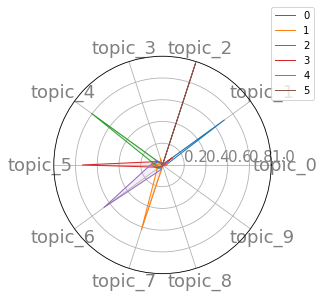

In [180]:
%matplotlib inline
plotModel(clustered_df,[0,1,2,3,4,5],"lda_cluster_id",nTopics,savename="spider_df.png")

We can also explore the topic distribution for the presorted HSD dataset. Of course, this does not work for the dataset building on random selection of books

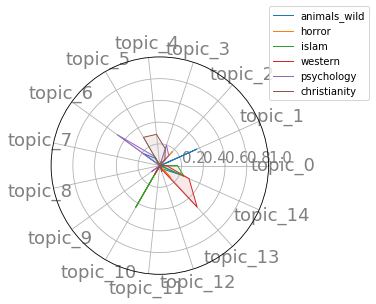

In [19]:
%matplotlib inline
plotModel(clustered_df,["animals_wild","horror","islam","western","psychology","christianity"],"category",nTopics,savename="spider_df.png")

Let us now turn our attention towards the other dataset, which have been presorted by humans into categories such as Horror, Western etc. Lets explore how this sorting compares to what our algorithms do

In [9]:
useRandomSet=False
nRandomTitles=500
basePath= "C:/Users/david.murer/gutenberg_capstone_project/data/"

In [10]:
parsing=TextProcessor(basePath,useRandomSet,nRandomTitles)

In [11]:
%%time
dictionary= corpora.Dictionary()
paths=parsing.returnAllPaths()
for path in paths:
    author,title,full_text,endFound=parsing.openFileWithIds(path)
    document=parsing.preProcessText(full_text,title)
    dictionary.add_documents([document])
    
dictionary.save('./dictionary_with_stemming.dict')  # store the dictionary, for future reference

end not found for filepathC:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\anthropology\haeckel_evoluation_man.txt
C:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\anthropology\haeckel_evoluation_man.txt
end not found for filepathC:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\christianity\pg1653.txt
C:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\christianity\pg1653.txt
Wall time: 3min 37s


Lets us explore the dictionary

In [46]:
dictionary.num_docs

202

In [47]:
dictionary.num_pos

7459828

Number of terms in the dictionary

In [48]:
len(dictionary.items())

163556

In the report, investigations are shown into the effect on the filter portion as well as the number of topics and number of clusters on the different metrics. Lets just investigate two cases: first, one with high Silhouette score: low number of topics, high number of clusters.

In [70]:
dictionary=dictionary.load('./dictionary_with_stemming.dict')
nTopics=3
nClusters=19
dictionary.filter_extremes(no_below=10,no_above=0.4)

In [71]:
%%time
nWordsInDictionary=len(dictionary.items())
corpus=Corpus(dictionary,parsing)
model = models.LdaModel(corpus, id2word=dictionary, num_topics=nTopics,passes=4,iterations=50000)

end not found for filepathC:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\anthropology\haeckel_evoluation_man.txt
C:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\anthropology\haeckel_evoluation_man.txt
end not found for filepathC:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\christianity\pg1653.txt
C:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\christianity\pg1653.txt
Wall time: 1min 10s


Now, cluster the documents

In [72]:
#clustering with LDA
transformed_corpus=model[corpus]
cluster_matrix= matutils.corpus2csc(transformed_corpus).T
clusterer_lda=KMeans(nClusters,max_iter=1000)
clusterer_lda.fit(cluster_matrix)

#clustering
pca=PCA(n_components=nTopics)
full_matrix=matutils.corpus2dense(corpus,nWordsInDictionary)
pca.fit(full_matrix.T)
pca_reduced_corpus=pca.transform(full_matrix.T)
clusterer_pca= KMeans(nClusters)
clusterer_pca.fit(pca_reduced_corpus)
    
clustered_df=classifyDocuments(parsing,clusterer_lda,clusterer_pca,dictionary,model,pca_reduced_corpus)

end not found for filepathC:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\anthropology\haeckel_evoluation_man.txt
C:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\anthropology\haeckel_evoluation_man.txt
end not found for filepathC:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\christianity\pg1653.txt
C:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\christianity\pg1653.txt


Lets just first check how well separated the clusters are using the silhouette score. Details are in the report

In [73]:
silhouette_score(clustered_df.loc[:,'topic_0':'topic_2'],clustered_df['lda_cluster_id'])

0.7464766583822534

Now we can compare the adjusted mutual information and adjusted RAND score

In [74]:
clustered_df["category_num"] = clustered_df["category"].astype('category').cat.codes
adjusted_mutual_info_score(clustered_df["lda_cluster_id"],clustered_df["category_num"])

0.23639919748976532

In [75]:
adjusted_rand_score(clustered_df["lda_cluster_id"],clustered_df["category_num"])

0.13572854743950752

Same thing for the PCA clusterings - is the LDA clustering more similar to the human clustering than the clustering based on PCA reduced data? A little bit - but not by much.

In [76]:
adjusted_mutual_info_score(clustered_df["pca_cluster_id"],clustered_df["category_num"])

0.11063527986679578

In [77]:
adjusted_rand_score(clustered_df["pca_cluster_id"],clustered_df["category_num"])

0.02566847727434047

What are the most frequent words in the topics?

In [78]:
model.print_topics(num_words=20)

[(0,
  u'0.005*"gram" + 0.005*"carbon" + 0.004*"sulphur" + 0.004*"oxid" + 0.003*"arteri" + 0.003*"darwin" + 0.003*"oxygen" + 0.003*"hydrogen" + 0.003*"dilut" + 0.003*"strata" + 0.002*"chlorid" + 0.002*"fossil" + 0.002*"lime" + 0.002*"ammonia" + 0.002*"solubl" + 0.002*"sodium" + 0.002*"membran" + 0.002*"filter" + 0.002*"sulphat" + 0.002*"larva"'),
 (1,
  u'0.006*"sexual" + 0.004*"denot" + 0.003*"jack" + 0.003*"cave" + 0.003*"unto" + 0.003*"captain" + 0.003*"manuel" + 0.002*"cotyledon" + 0.002*"whilst" + 0.002*"wade" + 0.002*"maid" + 0.002*"psycholog" + 0.002*"radicl" + 0.002*"seedl" + 0.002*"foretel" + 0.002*"moor" + 0.002*"vertic" + 0.002*"festiv" + 0.002*"didnt" + 0.001*"tendril"'),
 (2,
  u'0.007*"christ" + 0.005*"brethren" + 0.004*"pollen" + 0.004*"gland" + 0.004*"coven" + 0.003*"tentacl" + 0.003*"inflect" + 0.003*"cathol" + 0.003*"arab" + 0.003*"prophet" + 0.003*"jesu" + 0.003*"fertilis" + 0.003*"darwin" + 0.003*"capsul" + 0.003*"krishna" + 0.003*"unto" + 0.002*"soap" + 0.002*"budd

Lets investigate the topics a bit. Lets compare the topic distribution of books in the natural science. It seems that topic 0 sort of emerged as a topic which is relevant for all the books in natural science, with almost no contribution to religious books. The latter are described by topic 2. Clearly, there is a common uncerlying structure in the topics

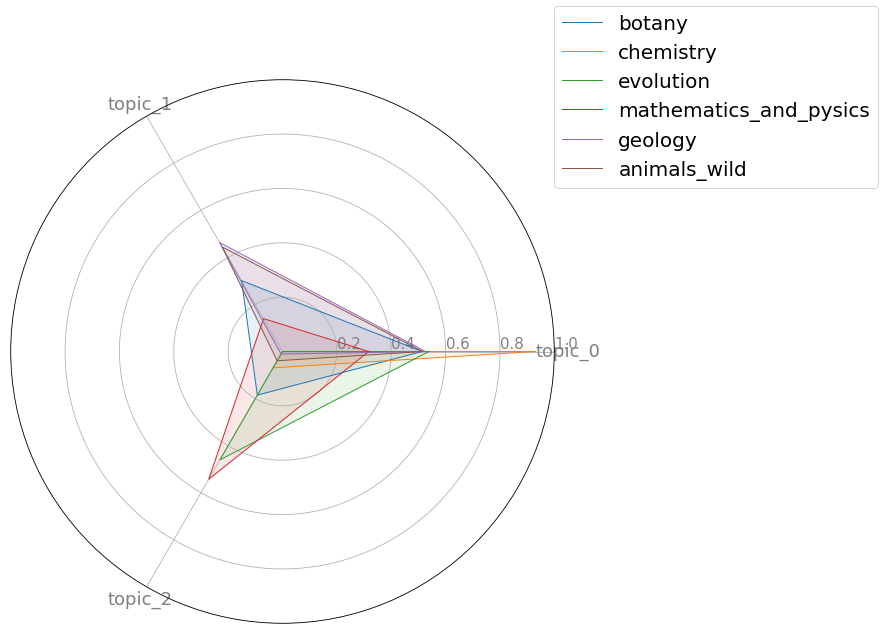

In [104]:
plotModel(clustered_df,["botany","chemistry","evolution","mathematics_and_pysics","geology","animals_wild"],"category",nTopics,savename="spider1.png")

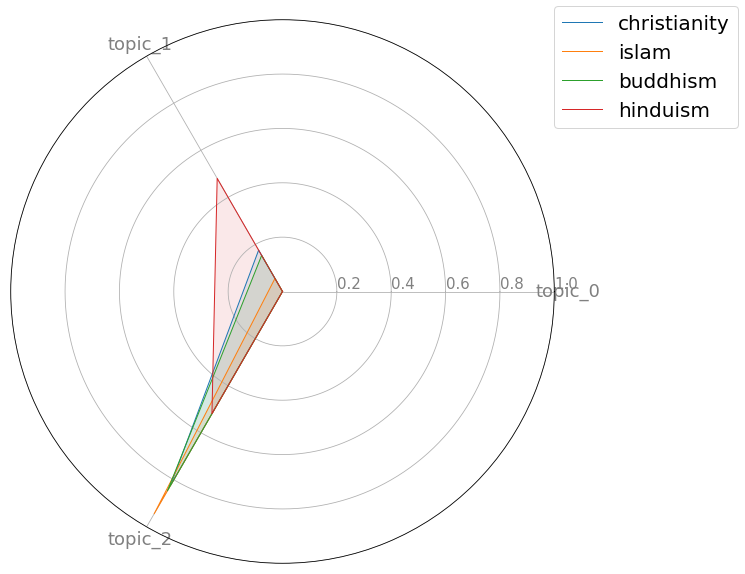

In [105]:
plotModel(clustered_df,["christianity","islam","buddhism","hinduism"],"category",nTopics,savename="spider1.png")

Lets explore the clusters we have achieved using these parameters - start with cluster 0 - a huge cluster, containing 53 books. All of the documents of this cluster are describes almost exlusively with topic 1. When we look into Topic 2, its not that easy to predict much. Sex, captain, caves, plant related terms. 

In [106]:
clustered_df[clustered_df['lda_cluster_id']==0]

,fname,author,title,random_cluster_id,lda_cluster_id,pca_cluster_id,category,topic_0,topic_1,topic_2,category_num
9,long_ways_of_wood_fold.txt,William J. Long,Ways of Wood Folk,15,0,0,animals_wild,0,0.999782,0,0
10,long_wilderness_ways.txt,William J Long,Wilderness Ways,5,0,0,animals_wild,0,0.999703,0,0
15,roberts_watchers_trails.txt,Charles G. D. Roberts,The Watchers of the Trails,18,0,0,animals_wild,0.0192447,0.9807,0,0
17,frazer_golden_bough.txt,Sir James George Frazer,The Golden Bough,8,0,17,anthropology,0,0.961189,0.0387997,1
18,harrison_ancient_art_and_ritual.txt,Jane Ellen Harrison,Ancient Art and Ritual,13,0,0,anthropology,0,0.956731,0.0431675,1
34,pg5605.txt,Charles Darwin,The Power of Movement in Plants,11,0,14,botany,0.0385014,0.961471,0,2
75,244-0.txt,Arthur Conan Doyle,A Study In Scarlet,12,0,0,detective_fiction,0.0101938,0.989655,0,6
76,2852-0.txt,A. Conan Doyle,The Hound of the Baskervilles,18,0,0,detective_fiction,0,0.999759,0,6
77,863-0.txt,Agatha Christie,The Mysterious Affair at Styles,0,0,0,detective_fiction,0.0356998,0.964173,0,6
78,pg11128.txt,R. Austin Freeman,The Red Thumb Mark,10,0,13,detective_fiction,0.0366476,0.963263,0,6


Cluster 2 is interesting - Almost solely topic 0, which from the most frequent word one would expect books in biology and chemistry - which is indeed the case

In [96]:
clustered_df[clustered_df['lda_cluster_id']==2]

,fname,author,title,random_cluster_id,lda_cluster_id,pca_cluster_id,category,topic_0,topic_1,topic_2,category_num
6,haseman_elementary_study_insects.txt,Leonard Haseman,An Elementary Study of Insects,2,2,0,animals_wild,0.99949,0,0,0
11,lucas_animals_of_the_past.txt,Frederic A. Lucas,Animals of the Past,3,2,13,animals_wild,0.999762,0,0,0
13,morley_insect_folk.txt,Margaret Warner Morley,The Insect Folk,7,2,0,animals_wild,0.958021,0.0418204,0,0
14,packard_common_insects.txt,Alpheus Spring Packard,Our Common Insects,7,2,13,animals_wild,0.999878,0,0,0
22,20390-0.txt,Douglas Houghton Campbell,Elements of Structural and Systematic Botany,9,2,10,botany,0.99988,0,0,2
26,pg10852.txt,A. D. Webster,Hardy Ornamental Flowering Trees and Shrubs,17,2,13,botany,0.999857,0,0,2
27,pg16116.txt,Jacob Joshua Levison,Studies of Trees,12,2,13,botany,0.999795,0,0,2
28,pg24063.txt,Rai Bahadur K. Ranga Achariyar,A Handbook of Some South Indian Grasses,14,2,10,botany,0.999886,0,0,2
29,pg26393.txt,T. H. Pardo de Tavera,The Medicinal Plants of the Philippines,17,2,15,botany,0.999922,0,0,2
43,pg12787.txt,Henry P. Talbot,An Introductory Course of Quantitative Chemica...,1,2,7,chemistry,0.999899,0,0,4


In general, the size of the clusters is highly uneven - some of the clusters contain dozens of books, often described by a single topic. Other clusters are very small. Some of these clusters reveal very interesting, highly specialized topics.
For example, cluster 6 seems to deal with insects a lot. For example, the book "Wonders of Instinct" has the subtitle: "CHAPTERS IN THE PSYCHOLOGY OF INSECTS". The title "little busybodies" deals with insects as well . The other two books deal with plants - however in a very special way. "The Botanic Garden" is a poem, with highly anthropormorphized pictures of plants, while "Getting Acquainted with the Trees" seems to more an ode to the plants than highly scientific exploration. 

In [114]:
clustered_df[clustered_df['lda_cluster_id']==6]

,fname,author,title,random_cluster_id,lda_cluster_id,pca_cluster_id,category,topic_0,topic_1,topic_2,category_num
3,fabre_social_life_insects.txt,J. H. Fabre,Social Life in the Insect World,2,6,13,animals_wild,0.75808,0.241872,0,0
4,fabre_wonders_instinct.txt,J. H. Fabre,The Wonders of Instinct,9,6,13,animals_wild,0.693704,0.306246,0,0
16,unknown_little_busybodies.txt,Jeanette Augustus Marks and Julia Moody,Little Busybodies,18,6,0,animals_wild,0.637575,0.362266,0,0
32,pg28764.txt,J. Horace McFarland,Getting Acquainted with the Trees,1,6,0,botany,0.644891,0.354991,0,2
36,pg9612.txt,Erasmus Darwin,The Botanic Garden,3,6,16,botany,0.745759,0.254209,0,2


Not all clusters revleal such interesting connections - but often clear similarities exist. Let us now explore what happens when we increase the number of topics

In [135]:
dictionary=dictionary.load('./dictionary_with_stemming.dict')
nTopics=10
nClusters=19
dictionary.filter_extremes(no_below=5,no_above=0.7)

In [136]:
%%time
nWordsInDictionary=len(dictionary.items())
corpus=Corpus(dictionary,parsing)
model = models.LdaModel(corpus, id2word=dictionary, num_topics=nTopics,passes=4,iterations=50000)

end not found for filepathC:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\anthropology\haeckel_evoluation_man.txt
C:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\anthropology\haeckel_evoluation_man.txt
end not found for filepathC:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\christianity\pg1653.txt
C:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\christianity\pg1653.txt
Wall time: 1min 23s


In [137]:
#clustering with LDA
transformed_corpus=model[corpus]
cluster_matrix= matutils.corpus2csc(transformed_corpus).T
clusterer_lda=KMeans(nClusters,max_iter=1000)
clusterer_lda.fit(cluster_matrix)

#clustering
pca=PCA(n_components=nTopics)
full_matrix=matutils.corpus2dense(corpus,nWordsInDictionary)
pca.fit(full_matrix.T)
pca_reduced_corpus=pca.transform(full_matrix.T)
clusterer_pca= KMeans(nClusters)
clusterer_pca.fit(pca_reduced_corpus)
    
clustered_df=classifyDocuments(parsing,clusterer_lda,clusterer_pca,dictionary,model,pca_reduced_corpus)

end not found for filepathC:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\anthropology\haeckel_evoluation_man.txt
C:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\anthropology\haeckel_evoluation_man.txt
end not found for filepathC:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\christianity\pg1653.txt
C:\Users\david.murer\gutenberg_capstone_project\data\gutenberg_books_sorted\christianity\pg1653.txt


Printing the Silhouette score as well as the AMI/ARI score, one can see that the clusters get less pronounced (lower Sihouette score), but in general more similar to the prexisting clusterings

In [138]:
silhouette_score(clustered_df.loc[:,'topic_0':'topic_14'],clustered_df['lda_cluster_id'])

0.5385713536617681

In [139]:
clustered_df["category_num"] = clustered_df["category"].astype('category').cat.codes
adjusted_mutual_info_score(clustered_df["lda_cluster_id"],clustered_df["category_num"])

0.4124556130289299

In [140]:
adjusted_rand_score(clustered_df["lda_cluster_id"],clustered_df["category_num"])

0.2653875292182895

Lets go through the same steps: most common words for the topics

In [141]:
model.print_topics(num_words=10)

[(0,
  u'0.007*"church" + 0.004*"brethren" + 0.004*"repli" + 0.004*"king" + 0.003*"dont" + 0.003*"john" + 0.003*"england" + 0.003*"manuel" + 0.003*"girl" + 0.003*"christian"'),
 (1,
  u'0.019*"acid" + 0.015*"solut" + 0.008*"gram" + 0.007*"speci" + 0.007*"seed" + 0.006*"carbon" + 0.005*"colour" + 0.005*"cent" + 0.005*"sulphur" + 0.005*"precipit"'),
 (2,
  u'0.009*"glume" + 0.008*"acid" + 0.007*"ship" + 0.006*"captain" + 0.005*"compound" + 0.005*"carbon" + 0.005*"oxygen" + 0.005*"spikelet" + 0.005*"boat" + 0.004*"hydrogen"'),
 (3,
  u'0.003*"nest" + 0.003*"ration" + 0.003*"insect" + 0.003*"motu" + 0.003*"silent" + 0.003*"dont" + 0.002*"corpu" + 0.002*"quod" + 0.002*"creatur" + 0.002*"sunt"'),
 (4,
  u'0.006*"strata" + 0.006*"unto" + 0.006*"bed" + 0.006*"thou" + 0.006*"insect" + 0.005*"fossil" + 0.005*"wade" + 0.005*"speci" + 0.004*"herd" + 0.004*"deposit"'),
 (5,
  u'0.007*"diseas" + 0.007*"arteri" + 0.007*"vessel" + 0.007*"muscl" + 0.006*"patient" + 0.006*"plate" + 0.005*"tissu" + 0.005

Compared to the case with small number of topics, this time each category belongs strong to a single topic. Interesting to observe that the topics for Math&physics are distributed among the other natural science, and botany is split between topics on evoluation and chemistry.

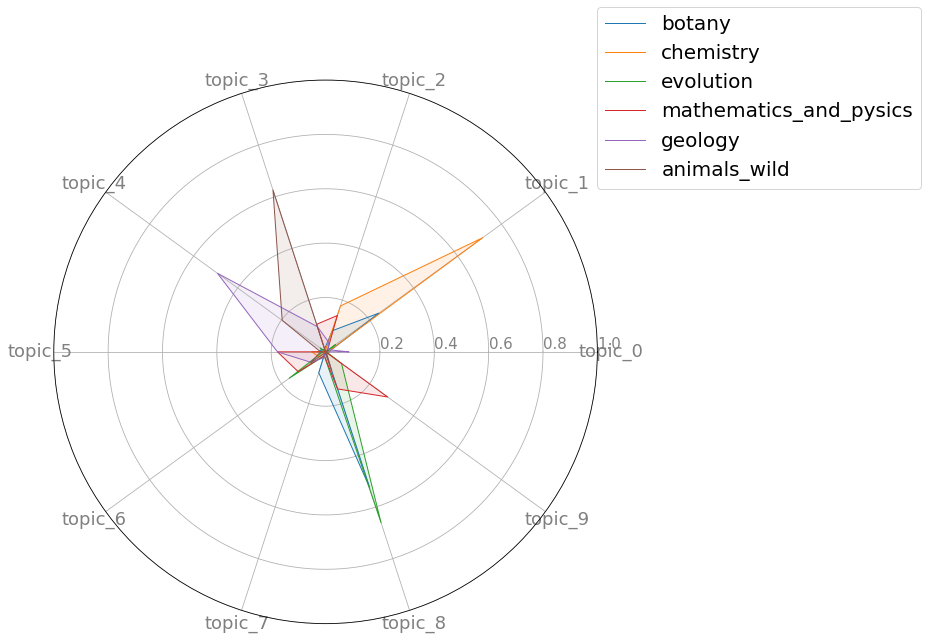

In [142]:
plotModel(clustered_df,["botany","chemistry","evolution","mathematics_and_pysics","geology","animals_wild"],"category",nTopics,savename="spider1.png")

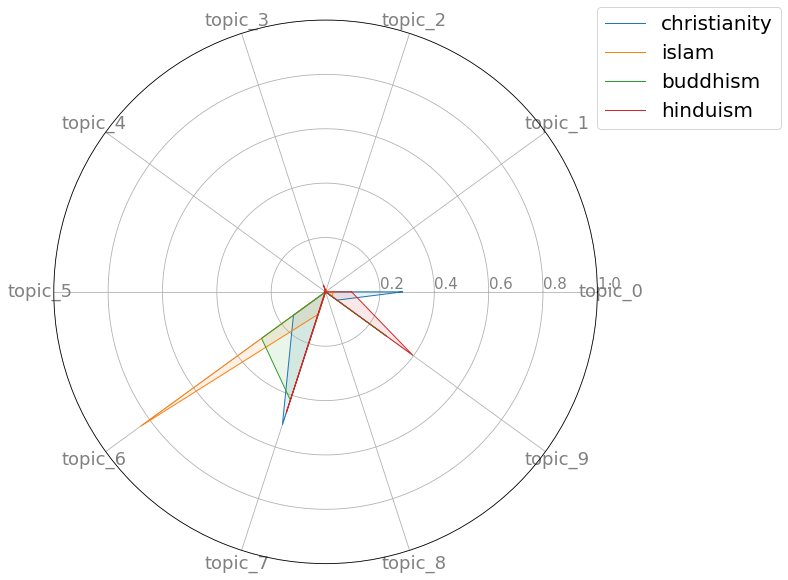

In [143]:
plotModel(clustered_df,["christianity","islam","buddhism","hinduism"],"category",nTopics,savename="spider1.png")

Going through the clusters, what was measured previously that the similarity between human and LDA clusterings increases becomes apparent. Even more interesting are the cases when books of different categories end up in the same clusters, which are still obviously very related, as exampllified in cluster 2. Note the distribution on the topics: the books which seem to be outlier, e.g. "10'000 dreams by Miller", are deviate from the topic distribution and are farther from the cluster center than the other books

In [153]:
clustered_df[clustered_df['lda_cluster_id']==2]

,fname,author,title,random_cluster_id,lda_cluster_id,pca_cluster_id,category,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,category_num
22,20390-0.txt,Douglas Houghton Campbell,Elements of Structural and Systematic Botany,16,2,0,botany,0,0.285092,0,0,0,0.0132502,0,0,0.701603,0,2
23,2485-0.txt,Charles Darwin,The Movement and Habits of Climbing Plants,0,2,0,botany,0,0,0,0,0,0,0,0,0.998086,0,2
26,pg10852.txt,A. D. Webster,Hardy Ornamental Flowering Trees and Shrubs,0,2,15,botany,0,0,0,0,0,0,0,0,0.999914,0,2
27,pg16116.txt,Jacob Joshua Levison,Studies of Trees,6,2,0,botany,0,0,0,0,0,0.0306089,0,0,0.962197,0,2
30,pg2871.txt,Charles Darwin,The Variation of Animals and Plants under Dome...,9,2,8,botany,0,0,0,0,0,0,0,0,0.999974,0,2
31,pg2872.txt,Charles Darwin,The Variation of Animals and Plants under Dome...,9,2,8,botany,0,0,0,0,0,0,0,0,0.999974,0,2
32,pg28764.txt,J. Horace McFarland,Getting Acquainted with the Trees,13,2,0,botany,0.170988,0,0,0.095911,0,0,0.0447682,0.0321978,0.656062,0,2
34,pg5605.txt,Charles Darwin,The Power of Movement in Plants,4,2,18,botany,0,0,0,0,0,0,0,0,0.999966,0,2
85,darwin_foundations_origin_species.txt,Charles Darwin,The Foundations of the Origin of Species,3,2,15,evolution,0,0,0,0,0.0106713,0,0,0,0.988123,0,7
88,gray_darwiniana.txt,Asa Gray,Darwiniana,17,2,15,evolution,0,0.0244585,0,0,0,0,0.10834,0,0.801603,0.0655623,7


In [158]:
clustered_df[clustered_df['lda_cluster_id']==12]

,fname,author,title,random_cluster_id,lda_cluster_id,pca_cluster_id,category,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,category_num
17,frazer_golden_bough.txt,Sir James George Frazer,The Golden Bough,14,12,12,anthropology,0,0,0,0,0,0,0,0.999988,0,0,1
18,harrison_ancient_art_and_ritual.txt,Jane Ellen Harrison,Ancient Art and Ritual,12,12,0,anthropology,0,0,0,0,0,0,0.0257108,0.834693,0,0.139512,1
37,7015-0.txt,Shinran Shonin,Buddhist Psalms,1,12,0,buddhism,0,0,0,0,0,0,0,0.932563,0,0.0671713,3
39,pg14360.txt,Henry Thayer Niles,The Dawn and the Day,5,12,0,buddhism,0,0,0.0143972,0.0658531,0,0,0,0.919666,0,0,3
60,8202-0.txt,Charles Kingsley,Sermons on National Subjects,18,12,5,christianity,0,0,0,0,0,0,0,0.999955,0,0,5
61,pg10116.txt,Charles Kingsley,All Saints' Day and Other Sermons,15,12,16,christianity,0,0,0,0,0,0,0,0.999943,0,0,5
62,pg11381.txt,Charles Kingsley,Sermons for the Times,3,12,16,christianity,0,0,0,0,0,0,0,0.999915,0,0,5
63,pg11536.txt,Charles Kingsley,Town and Country Sermons,8,12,16,christianity,0,0,0,0,0,0,0,0.999921,0,0,5
65,pg13460.txt,Marcus Dods,How to become like Christ,17,12,0,christianity,0.0571006,0,0,0,0,0,0,0.863839,0,0.0787484,5
67,pg19100.txt,Various,The Covenants And The Covenanters,17,12,5,christianity,0.0127856,0,0,0,0,0,0,0.987183,0,0,5
